In [3]:
import numpy as np
import matplotlib.pyplot as plt


class Map:
    
    def __init__(self, pos: tuple, shape: tuple, scale: float) -> None:
        self.pos = np.array(pos, dtype=np.int16)
        self.array = np.zeros(shape, dtype=np.uint16)
        self.scale = scale
    
    
    def __contains__(self, value) -> bool:
        i = np.array(value)
        low, high = self.limits()
        return all(i >= low) and all(i < high)
    
    
    def __getitem__(self, key) -> int | np.ndarray:
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        return self.array[*index]
    
    
    def __setitem__(self, key, value: int):
        if key not in self:
            raise IndexError(f'За границами карты {key}')
        i = np.array(key)
        index = i - self.pos[:i.size]
        self.array[*index] = value
    
    
    def limits(self) -> tuple[np.ndarray, np.ndarray]:
        return self.pos, self.pos + self.array.shape
    
    
    def update(self, other):
        if self.scale != other.scale:
            raise ValueError(f'Масштаб карт при сложении отличается: {self.scale} и {other.scale}')
        low1, high1 = self.limits()
        low2, high2 = other.limits()
        new_pos = np.min(np.vstack((low1, low2)), axis=0)
        new_high = np.max(np.vstack((high1, high2)), axis=0)
        new_array = np.zeros(new_high-new_pos, dtype=np.uint16)
        new_array[*[slice(l, h) for l, h in zip(low1-new_pos, low1-new_pos + np.array(self.array.shape))]] += self.array
        new_array[*[slice(l, h) for l, h in zip(low2-new_pos, low2-new_pos + np.array(other.array.shape))]] += other.array
        self.pos = new_pos
        self.array = new_array
        

    def show(self):
        x_min, y_max, x_max, y_min = np.concatenate(self.limits())*self.scale
        plt.imshow(self.array, cmap='gray_r', extent=[y_max, y_min, x_max, x_min])
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.grid(which='both')


def new_measurement(coords: np.ndarray, data: np.ndarray, scale: float) -> Map:
    x, y, rot = coords
    angle = np.linspace(-2*np.pi/3, 2*np.pi/3, len(data))
    data[data == 5.6] = np.nan
    data[data < 0.3] = np.nan
    xs = np.array([x + data * np.cos(rot-angle)]).transpose()
    ys = np.array([y + data * np.sin(rot-angle)]).transpose()
    points = np.hstack((xs, ys))
    points = points[~np.isnan(points).any(axis=1)]
    decomposed = (points // np.array([scale, scale])).astype(np.int16)
    decoposed_coords, counts = np.unique(decomposed, axis=0, return_counts=True)
    x_min, y_min, x_max, y_max = *decoposed_coords.min(axis=0), *decoposed_coords.max(axis=0)
    size = np.array([x_max - x_min + 1, y_max - y_min + 1])
    TOPLEFT = np.array([x_min, y_min])
    cell_map = np.zeros(size, dtype=np.uint16)
    for coord, n in zip(decoposed_coords, counts):
        cell_map[*(coord-TOPLEFT)] = n
    cell_map = cell_map.transpose()
    obj = Map(tuple(reversed(TOPLEFT)), cell_map.shape, scale)
    obj.array = cell_map
    return obj

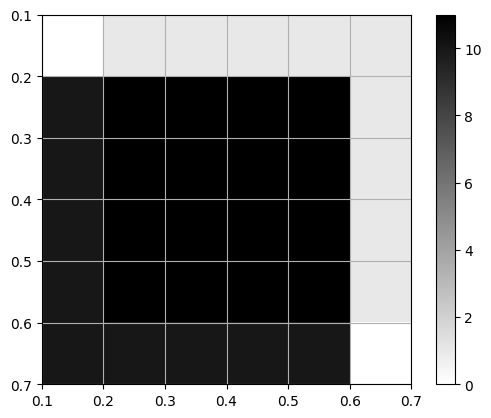

In [88]:
a = Map((1, 2), (5, 5), 0.1)
b = Map((2, 1), (5, 5), 0.1)
a.array += 1
b.array += 10
a.update(b)
a.show()

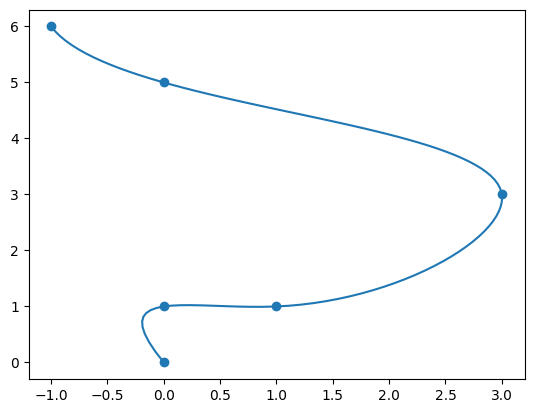

In [57]:
import numpy as np
import scipy.interpolate as interp

def interpolate_polyline(polyline, num_points):
    tck, u = interp.splprep(polyline.T, s=0)
    u = np.linspace(0.0, 1.0, num_points)
    return np.array(interp.splev(u, tck)).transpose()

A = np.array([[0, 0], [0, 1], [1, 1], [3, 3], [0, 5], [-1, 6]])

B = interpolate_polyline(A, 100)
plt.plot(*B.transpose())
plt.scatter(*A.transpose())

In [3]:
import numpy as np

trajectory = [np.array([0, 0]),
              np.array([0, 1]),
              np.array([2, 2]),
              np.array([4, 5]),
              np.array([6, 6])]


np.vstack([np.linspace(trajectory[i], point, 5, endpoint=False) for i, point in enumerate(trajectory[1:])])

array([[0. , 0. ],
       [0. , 0.2],
       [0. , 0.4],
       [0. , 0.6],
       [0. , 0.8],
       [0. , 1. ],
       [0.4, 1.2],
       [0.8, 1.4],
       [1.2, 1.6],
       [1.6, 1.8],
       [2. , 2. ],
       [2.4, 2.6],
       [2.8, 3.2],
       [3.2, 3.8],
       [3.6, 4.4],
       [4. , 5. ],
       [4.4, 5.2],
       [4.8, 5.4],
       [5.2, 5.6],
       [5.6, 5.8]])

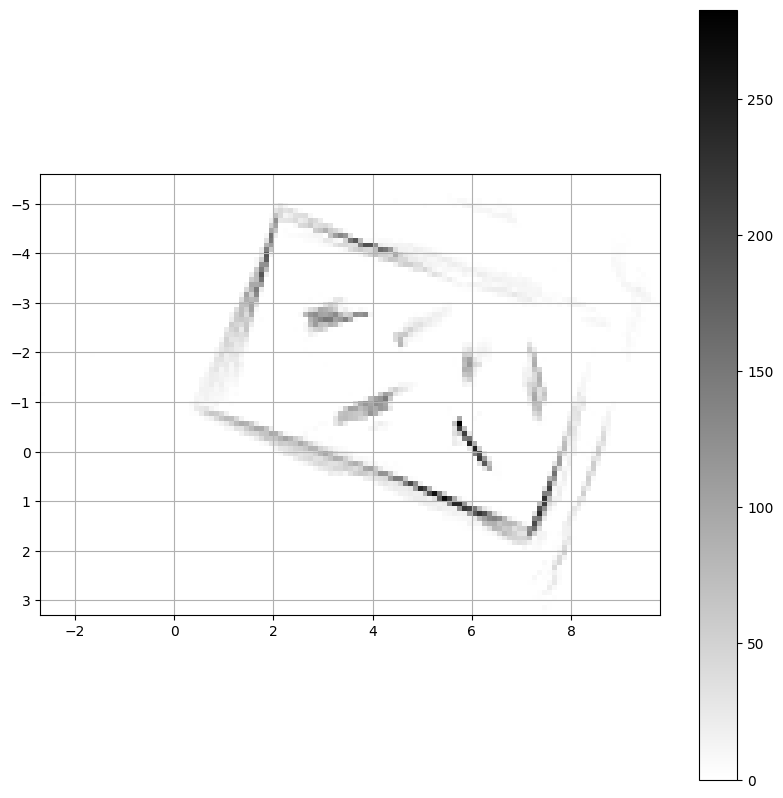

In [5]:
SCALE = 0.1

plt.figure(figsize=(10, 10))
with open("examples/examp7.txt") as file:
    for i, line in enumerate(file):
        c, d = line.split("; ")
        coords = np.array([float(number) for number in c.split(", ")])
        data = np.array([float(number) for number in d.split(", ")])
        if i == 0:
            a = new_measurement(coords, data, SCALE)
        else:
            a.update(new_measurement(coords, data, SCALE))
a.show()

Scheme viz

In [2]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import schematics

class Sim:
    '''Represents sim. Use Sim.sim.{command}() to send commands to sim.'''
    
    client = RemoteAPIClient()
    sim = client.getObject('sim')
    client.setStepping(False)
    verbose = True  


scheme = schematics.open_scheme('schemes/default_scheme.json')

for coords, rot, shape in scheme.iterator():
    cube = Sim.sim.createPrimitiveShape(Sim.sim.primitiveshape_cuboid, list(shape))
    Sim.sim.setObjectPosition(cube, Sim.sim.handle_world, list(coords))
    Sim.sim.setObjectOrientation(cube, Sim.sim.handle_world, [0, 0, rot])

ModuleNotFoundError: No module named 'schematics'

In [6]:
def convert_from_uvd(u, v, d, f, c):
    x = (u - c[1]) * d / f
    y = (v - c[0]) * d / f
    z = d
    return np.array([x, y, z])
    

def new_measurement(coords: np.ndarray, data: np.ndarray, scale: float) -> Map:
    x, y, rot = coords
    angle = np.linspace(3*np.pi/8, -3*np.pi/8, len(data))
    data /= np.cos(angle)
    xs = np.array([x + data * np.cos(rot-angle)]).transpose()
    ys = np.array([y + data * np.sin(rot-angle)]).transpose()
    points = np.hstack((xs, ys))
    points = points[~np.isnan(points).any(axis=1)]
    decomposed = (points // np.array([scale, scale])).astype(np.int16)
    decoposed_coords, counts = np.unique(decomposed, axis=0, return_counts=True)
    x_min, y_min, x_max, y_max = *decoposed_coords.min(axis=0), *decoposed_coords.max(axis=0)
    size = np.array([x_max - x_min + 1, y_max - y_min + 1])
    TOPLEFT = np.array([x_min, y_min])
    cell_map = np.zeros(size, dtype=np.uint16)
    for coord, n in zip(decoposed_coords, counts):
        cell_map[*(coord-TOPLEFT)] = n
    cell_map = cell_map.transpose()
    obj = Map(tuple(reversed(TOPLEFT)), cell_map.shape, scale)
    obj.array = cell_map
    return obj

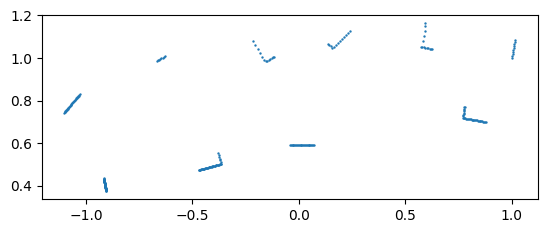

In [30]:
import struct
import time
SCALE = 0.01

Sim.sim.startSimulation()
time.sleep(0.5)
lidar = Sim.sim.getObject('/youBot/Lidar')
cloud = np.empty((3, 0))

start = time.time()
# while time.time()-start < 5:
depth, res = Sim.sim.getVisionSensorDepth(lidar)
pos = Sim.sim.getObjectPosition(lidar, Sim.sim.handle_world)
azimuth = Sim.sim.getObjectOrientation(lidar, Sim.sim.handle_world)
d = [struct.unpack('f', depth[i:i+4])[0] for i in range(0, len(depth), 4)]
data = np.array(d).reshape(res)
data[data > 0.99] = np.nan
data = data * (2 - 1e-4) + 1e-4
cloud = np.array([convert_from_uvd(u, v, data[v, u], data.shape[1]/2/np.tan(3*np.pi/8), np.array(data.shape)/2) for u in range(data.shape[1]) for v in range(data.shape[0])]).transpose()
cloud = cloud[:, ~np.isnan(cloud).any(axis=0)]

Sim.sim.stopSimulation()

plt.gca().set_aspect('equal')
plt.scatter(*cloud[[0, 2]], s=0.5)

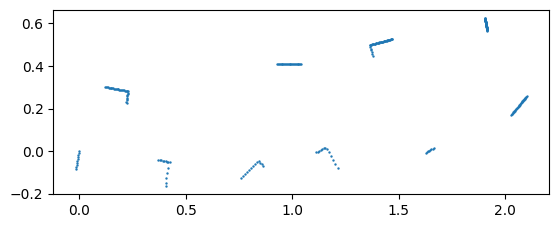

In [31]:
a = np.pi
matrix_z = np.array([[np.cos(a), -np.sin(a), 0.],
                     [np.sin(a), np.cos(a), 0.],
                     [0., 0., 1.]])

x, y, z = cloud
global_cloud = np.array([x, z, y])
cloud = (np.dot(global_cloud.transpose(), matrix_z) + np.array([1, 1, 0])).transpose()
plt.gca().set_aspect('equal')
plt.scatter(*cloud[:2], s=0.5)

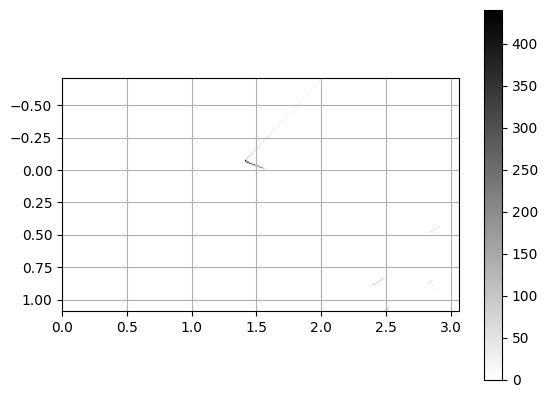

In [45]:
import struct
import time
start = time.time()
SCALE = 0.01

Sim.sim.startSimulation()
lidar = Sim.sim.getObject('/youBot/Lidar')
world_map = Map(Sim.sim.getObjectPosition(lidar, Sim.sim.handle_world)[:2], (0, 0), SCALE)

while time.time()-start < 5:
    depth, res = Sim.sim.getVisionSensorDepth(lidar)
    pos = Sim.sim.getObjectPosition(lidar, Sim.sim.handle_world)
    azimuth = Sim.sim.getObjectOrientation(lidar, Sim.sim.handle_world)
    d = [struct.unpack('f', depth[i:i+4])[0] for i in range(0, len(depth), 4)]
    data = np.array(d).reshape(res[1])*2 + 1e-04
    data[data > 1.9] = np.nan
    if np.isnan(data).all():
        continue
    world_map.update(new_measurement(coords, data, SCALE))
    time.sleep(0.1)

Sim.sim.stopSimulation()

world_map.show()

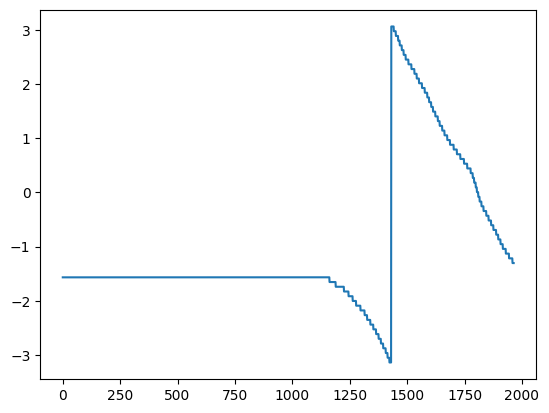

In [11]:
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import matplotlib.pyplot as plt

class Sim:
    '''Represents sim. Use Sim.sim.{command}() to send commands to sim.'''
    
    client = RemoteAPIClient()
    sim = client.getObject('sim')
    client.setStepping(False)
    verbose = True
      
Sim.sim.startSimulation()
ref = Sim.sim.getObject('./youBot_ref')
start = time.time()
angle = []
while time.time() - start < 10:
    angle.append(Sim.sim.getObjectOrientation(ref, Sim.sim.handle_world)[2])
Sim.sim.stopSimulation()
plt.plot(angle)

In [10]:
from kuka import *
from time import sleep

Sim.sim.startSimulation()
sleep(0.2)
robot = assemble_robot()
start = robot.platform.ref.get_pos()
robot.platform.travel_to((0., 1.5))
robot.platform.travel_to((0., 0.))
robot.platform.travel_to((2., 2.))
robot.platform.travel_to((1., 2.))
robot.platform.travel_to(start)
Sim.sim.stopSimulation()

Azimuth delta: 0.9682438700926401
Azimuth: -0.1822806610853256
Target: 0.7859632090073145

Azimuth delta: 0.9682369608366101
Azimuth: -0.18227375182929562
Target: 0.7859632090073145

Azimuth delta: 0.9682369608366101
Azimuth: -0.18227375182929562
Target: 0.7859632090073145

Azimuth delta: 0.9522508718512508
Azimuth: -0.16628766284393626
Target: 0.7859632090073145

Azimuth delta: 0.9522508718512508
Azimuth: -0.16628766284393626
Target: 0.7859632090073145

Azimuth delta: 0.9522508718512508
Azimuth: -0.12895205076279925
Target: 0.7859632090073145

Azimuth delta: 0.9149152597701138
Azimuth: -0.12895205076279925
Target: 0.7859632090073145

Azimuth delta: 0.9149152597701138
Azimuth: -0.08516593876903356
Target: 0.7859632090073145

Azimuth delta: 0.8711291477763481
Azimuth: -0.08516593876903356
Target: 0.7859632090073145

Azimuth delta: 0.8711291477763481
Azimuth: -0.08516593876903356
Target: 0.7859632090073145

Azimuth delta: 0.8274637145701853
Azimuth: -0.04150050556287077
Target: 0.7859632

1

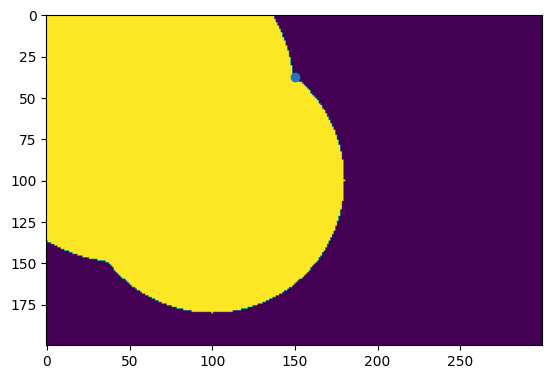

In [9]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt

bitmap = np.zeros((200, 300))
cv2.circle(bitmap, (50, 50), 100, 1, -1) # type: ignore
cv2.circle(bitmap, (100, 100), 80, 1, -1) # type: ignore
plt.imshow(bitmap)
target = np.array([100, 75])

bitmap = bitmap.transpose().astype(bool)
reachable_points = np.stack(np.meshgrid(np.arange(bitmap.shape[1]), np.arange(bitmap.shape[0])), axis=-1)[~bitmap].reshape(-1, 2)
if len(reachable_points) == 0:
    raise ValueError('No reachable points')
closest = min(reachable_points, key=lambda p: np.linalg.norm(target-p))
plt.scatter(*closest)

array([12.,  0.])

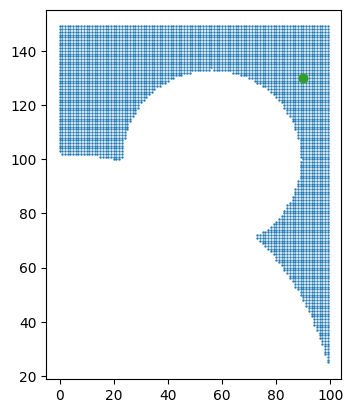

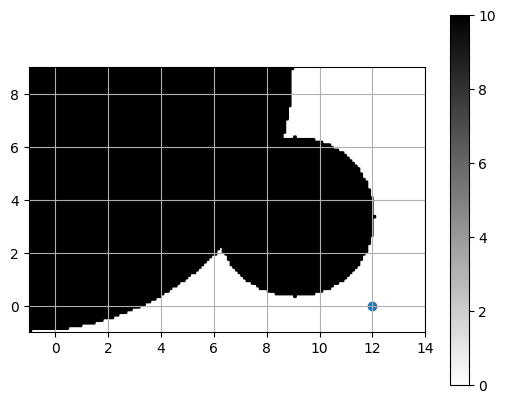

In [4]:
from navigation import Map
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt

M = Map((-10., -10.), (100, 150), 0.1)
img = M.array.astype(int)
cv2.circle(img, (0, 0), 99, 25, -1) # type: ignore
cv2.circle(img, (100, 56), 30, 25, -1) # type: ignore
M.array = img.astype(np.uint32)

closest = M.find_closest_to(np.array([12., 0.]))
plt.figure()
M.show()
plt.scatter(*closest)
closest

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


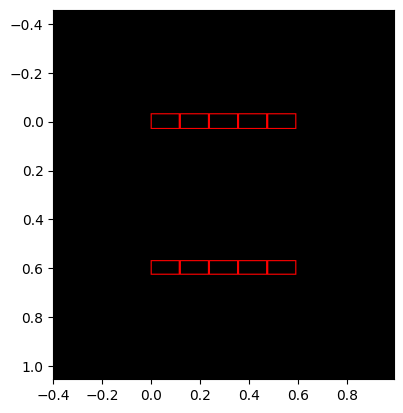

In [3]:
from schematics import *

scheme = open_scheme('schemes/parallel_scheme.json')
scheme.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def to_decart(q: np.ndarray, joint: int = 5) -> np.ndarray:
    return q

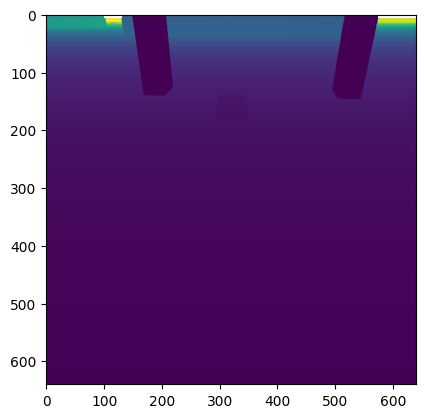

shape:  (640, 640)


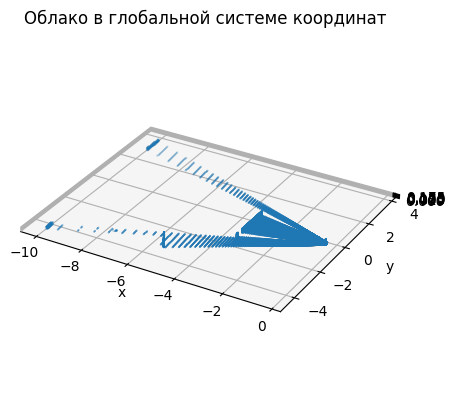

1

In [6]:
import matplotlib.pyplot as plt
from kuka import *
from time import sleep

Sim.sim.startSimulation()
sleep(0.5)
pc = Sim.sim.getObject('/PointCloud')
camera = VisionSensor(f'/youBot/Vision_sensor', Angle(60, True), (640, 640), 1e-4, 10.)
cloud = camera.get_cloud()
# for point in cloud.transpose():
#     Sim.sim.insertPointsIntoPointCloud(pc, 0, list(point))
Sim.sim.stopSimulation()

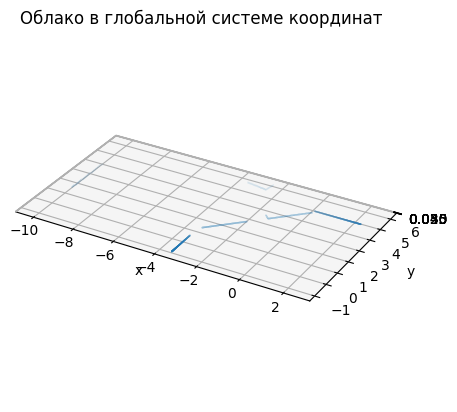

1

In [1]:
import matplotlib.pyplot as plt
from kuka import *
from time import sleep

Sim.sim.startSimulation()
sleep(0.5)
pc = Sim.sim.getObject('/PointCloud')
lidar = VisionSensor(f'/youBot/Lidar', Angle(135, True), (1, 680), 1e-4, 10.)
cloud = lidar.get_cloud()
# for point in cloud.transpose():
#     Sim.sim.insertPointsIntoPointCloud(pc, 0, list(point))
Sim.sim.stopSimulation()

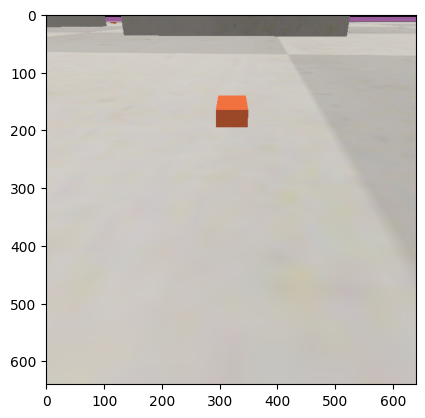

1

In [1]:
import matplotlib.pyplot as plt
from kuka import *
from time import sleep

Sim.sim.startSimulation()
sleep(0.5)
camera = VisionSensor(f'/youBot/Vision_sensor', Angle(60, True), (640, 640), 1e-4, 10.)
camera.shoot(True)
Sim.sim.stopSimulation()

In [1]:
from kuka import *
from main import Vision
from multiprocessing import Queue

Sim.sim.startSimulation()
sleep(0.5)
camera = VisionSensor(f'/youBot/Vision_sensor', Angle(60, True), (640, 640), 1e-4, 10.)
viz = Vision(Sim.lock, Queue()).scan()
Sim.sim.stopSimulation()

pygame-ce 2.4.0 (SDL 2.28.5, Python 3.11.5)


c:\Coding\Pathfinding\Navigation\main.py:59: RuntimeWarning: overflow encountered in scalar add
  mask = np.array([[pixel[2] < pixel[0] + pixel[1] for pixel in row] for row in cut_rgb], dtype=bool).flatten()


ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 0
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 4
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin shape: (8, 3)
FPS: 5
ICP
    cloud shape: (6, 3)
    origin s

KeyboardInterrupt: 

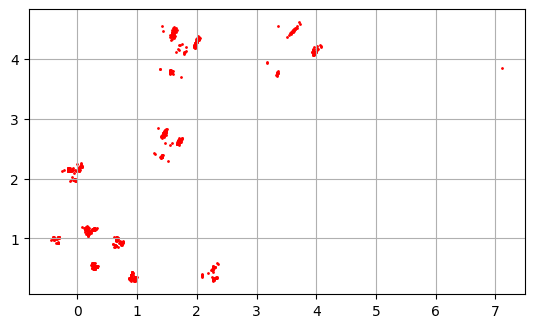

In [121]:
import numpy as np
import matplotlib.pyplot as plt

with open('detection_points.log', 'r') as f:
    data = np.array(list(map(float, f.read().split()))).reshape(-1, 4)
plt.scatter(data[:, 0], data[:, 1], s=1, c='r')
plt.grid()
plt.gca().set_aspect('equal')

[ 0  1  2 ...  2 12 10]


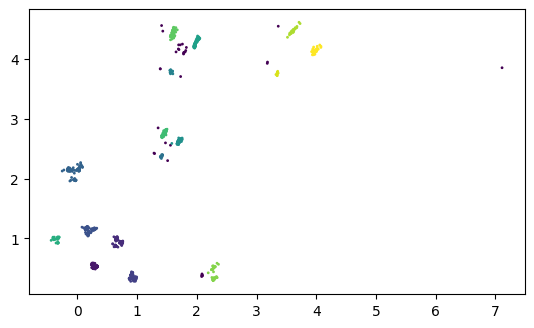

In [122]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.1, min_samples=10).fit_predict(data[:, :2])
plt.scatter(*data[:, :2].transpose(), s=1, c=clusters)
plt.gca().set_aspect('equal')


Cluster 0:
[0.27661354 0.5350165 ]

Cluster 1:
[0.67008711 0.93535639]

Cluster 2:
[0.92413792 0.34254829]

Cluster 3:
[0.18327541 1.15247907]

Cluster 4:
[-0.05018009  2.144469  ]

Cluster 5:
[1.40910231 2.36913112]

Cluster 6:
[1.56303028 3.78826014]

Cluster 7:
[1.69951231 2.62602629]

Cluster 8:
[1.98570269 4.28712816]

Cluster 9:
[-0.33120646  0.99916445]

Cluster 10:
[1.45886052 2.75749092]

Cluster 11:
[1.60521444 4.44239579]

Cluster 12:
[2.2797778 0.357721 ]

Cluster 13:
[3.61769391 4.48716659]

Cluster 14:
[3.34855974 3.7660854 ]

Cluster 15:
[3.9777614  4.13608185]


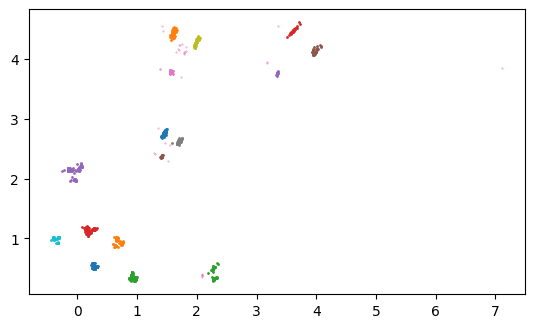

In [123]:
medians = []
means = []
for cluster in set(clusters):
    cloud = data[clusters == cluster, :2]
    if cluster == -1:
        plt.scatter(*cloud.transpose(), s=0.1)
        continue
    plt.scatter(*cloud.transpose(), s=1)
    print(f'\nCluster {cluster}:')
    print(np.median(cloud, axis=0))
    medians.append(np.median(cloud, axis=0))
    means.append(np.mean(cloud, axis=0))
plt.gca().set_aspect('equal')
medians = np.array(medians)
means = np.array(means)

In [124]:
from kuka import *

bricks = [Sim.sim.getObject(f'/Brick{i}') for i in range(1, 11)]
pos = np.array([Sim.sim.getObjectPosition(brick, Sim.sim.handle_world)[:2] for brick in bricks])
print("means error:")
for num in np.linalg.norm(pos[pos[:, 0].argsort()] - means[means[:, 0].argsort()], axis=1):
    print(f'{num:.3f}')
    
print("medians error:")
for num in np.linalg.norm(pos[pos[:, 0].argsort()] - medians[medians[:, 0].argsort()], axis=1):
    print(f'{num:.3f}')

means error:


ValueError: operands could not be broadcast together with shapes (10,2) (16,2) 

Dataset for segmentation

In [59]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import os

ROOT = 'dataset/'
IMG_TARGET = 'bricks2/images/train/'
NAME_TARGET = 'bricks2/names/train/'

lower_orange = np.array([140, 60, 30][::-1], dtype=np.uint8)
upper_orange = np.array([255, 140, 90][::-1], dtype=np.uint8)

for file in os.listdir(ROOT):
    img = cv2.imread(ROOT + file)
    try:
        mask = cv2.inRange(img, lower_orange, upper_orange)
    except cv2.error:
        print(file)
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cv2.imwrite(IMG_TARGET + file, img)
    with open(f'{NAME_TARGET}{file.split(".")[0]}.txt', 'w') as f:
        for c in contours:
            f.write(f'0 {" ".join(map(str, c.flatten()/640))}\n')

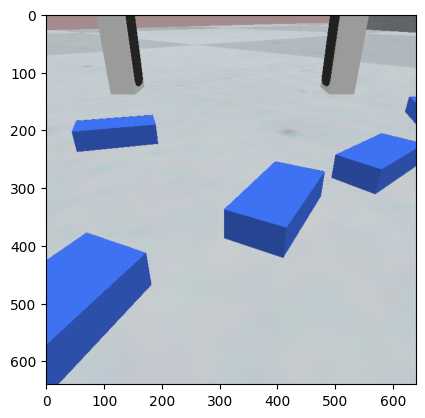

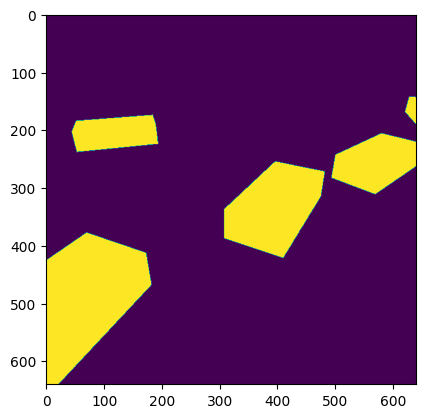

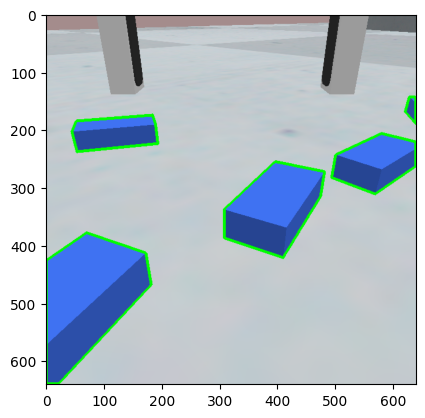

In [39]:
img = cv2.imread(ROOT + '1724.png')
plt.imshow(img)
lower_orange = np.array([140, 60, 30][::-1], dtype=np.uint8)
upper_orange = np.array([255, 140, 90][::-1], dtype=np.uint8)
mask = cv2.inRange(img, lower_orange, upper_orange)
plt.figure()
plt.imshow(mask)
plt.figure()
contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
found = cv2.drawContours(img, contours, -1, (0, 255 ,0), 3)
plt.imshow(found)

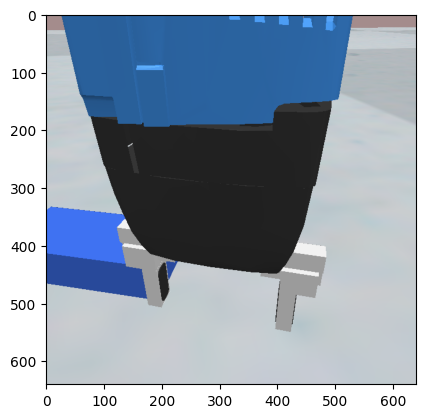

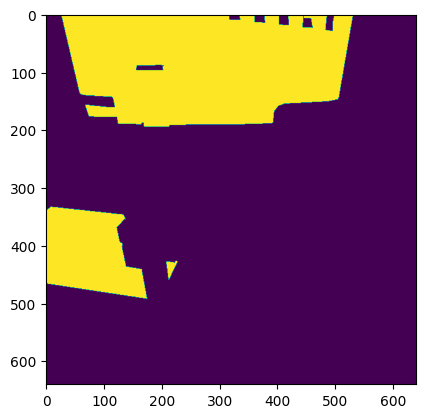

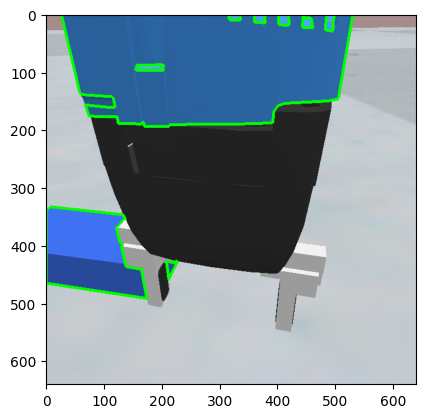

In [40]:
img = cv2.imread(ROOT + '2690.png')
plt.imshow(img)
mask = cv2.inRange(img, lower_orange, upper_orange)
plt.figure()
plt.imshow(mask)
plt.figure()
contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
found = cv2.drawContours(img, contours, -1, (0, 255 ,0), 3)
plt.imshow(found)

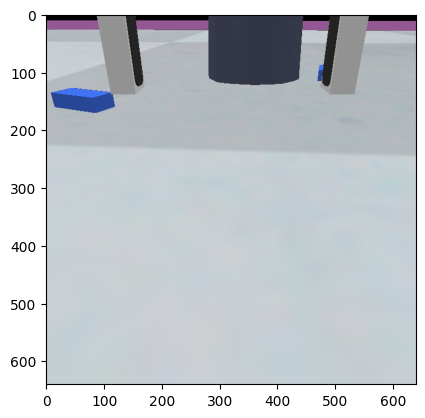

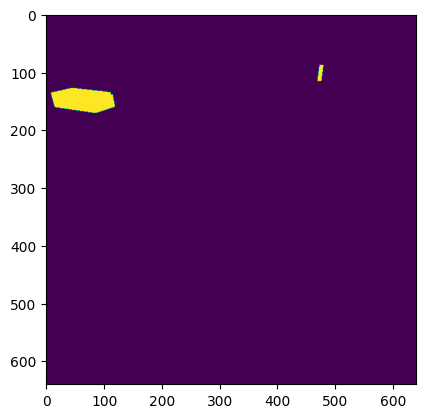

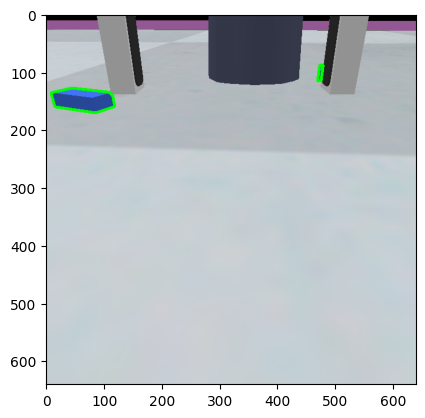

In [41]:
img = cv2.imread(ROOT + '1409.png')
plt.imshow(img)
mask = cv2.inRange(img, lower_orange, upper_orange)
plt.figure()
plt.imshow(mask)
plt.figure()
contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
found = cv2.drawContours(img, contours, -1, (0, 255 ,0), 3)
plt.imshow(found)

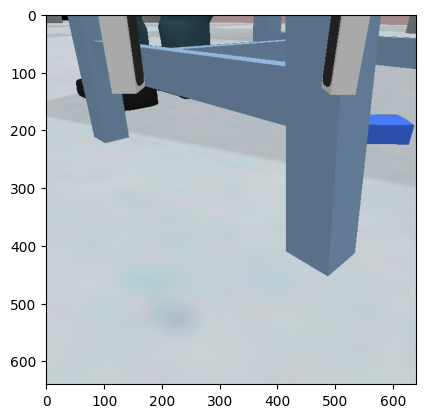

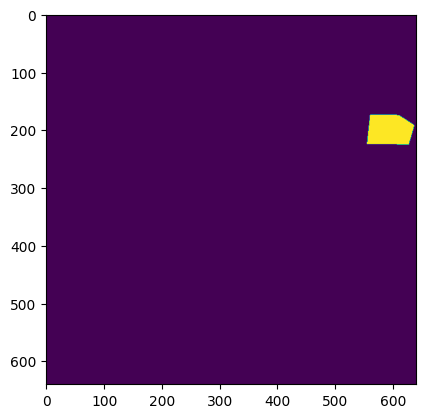

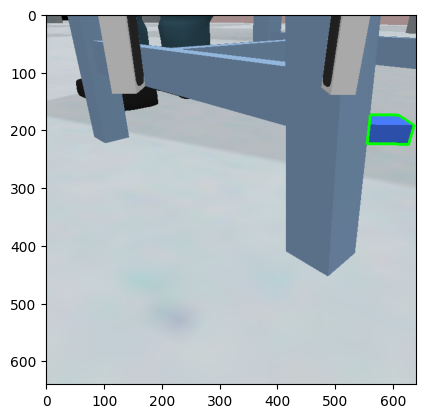

In [42]:
img = cv2.imread(ROOT + '1340.png')
plt.imshow(img)
mask = cv2.inRange(img, lower_orange, upper_orange)
plt.figure()
plt.imshow(mask)
plt.figure()
contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
found = cv2.drawContours(img, contours, -1, (0, 255 ,0), 3)
plt.imshow(found)

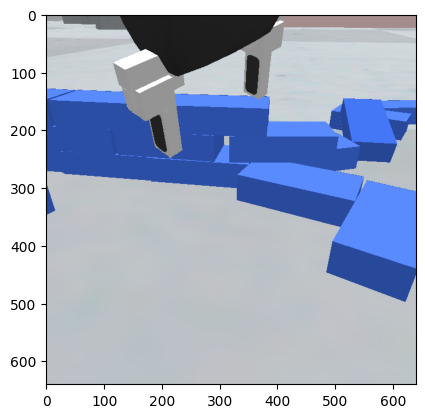

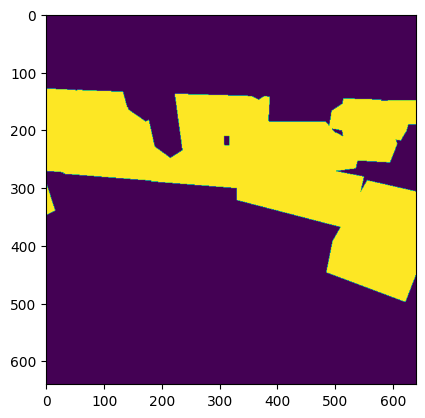

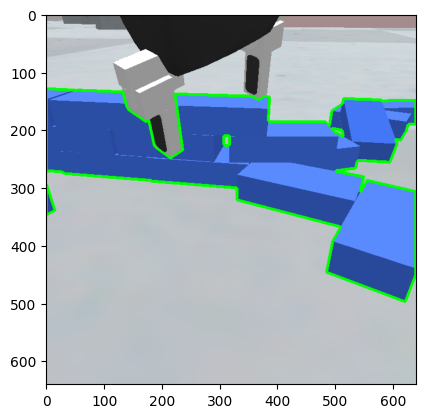

In [43]:
img = cv2.imread(ROOT + '2935.png')
plt.imshow(img)
mask = cv2.inRange(img, lower_orange, upper_orange)
plt.figure()
plt.imshow(mask)
plt.figure()
contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
found = cv2.drawContours(img, contours, -1, (0, 255 ,0), 3)
plt.imshow(found)

In [5]:
import cv2 as cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from main import Vision
from multiprocessing import Queue
from kuka import Sim

Sim.sim.startSimulation()
model = YOLO('yolo-seg-v3.pt')
viz = Vision(Sim.lock, Queue())

matrix, depth, img = viz.camera.shoot(do_rgb=True)
results = model.predict(img)
plt.imshow(img)
plt.show()
for result in results:
    for c in result:
        conf = round(c.boxes.conf[0].item(), 2)
        if conf < 0.5:
            continue
        print(conf)
        
        coords = [round(x) for x in c.boxes.xyxy.tolist()[0]]
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        c_mask = np.zeros(img.shape[:2], np.uint8)
        cv2.drawContours(c_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
        mask = c_mask[coords[1]:coords[3], coords[0]:coords[2]].astype(bool)
        cut_rgb = img[coords[1]:coords[3], coords[0]:coords[2]]
        # cloud = viz.camera.get_cloud(depth, matrix, tuple(coords[:2]), tuple(coords[2:]))[:, mask.flatten()]
        plt.figure()
        plt.subplot(221)
        plt.imshow(cut_rgb)
        plt.subplot(222)
        plt.imshow(mask)
Sim.sim.stopSimulation()

KeyboardInterrupt: 

2D

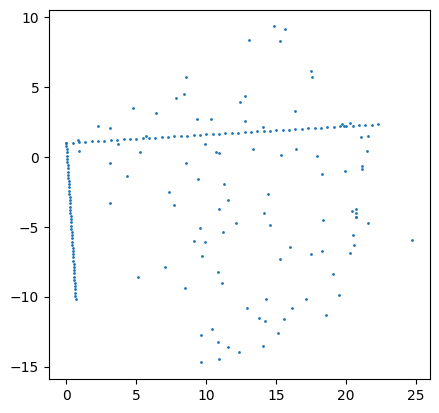

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2


def rotate2D(origin: tuple[float, float], cloud: np.ndarray, angle: float) -> np.ndarray:
    assert cloud.shape[0] == 2, 'wrong input shape'

    ox, oy = origin
    px, py = cloud

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return np.array([qx, qy])


def dist_points2line(points: np.ndarray, line: tuple[float, float, float]) -> np.ndarray:
    assert points.shape[0] == 2, 'wrong input shape'
    a, b, c = line
    return np.abs(a*points[0] + b*points[1] + c) / np.sqrt(a**2 + b**2)


def dist_points2plane(points: np.ndarray, plane: tuple[float, float, float, float]) -> np.ndarray:
    assert points.shape[0] == 3, 'wrong input shape'
    a, b, c, d = plane
    return np.abs(a*points[0] + b*points[1] + c*points[2] + d) / np.sqrt(a**2 + b**2 + c**2)
    
    
def line_by_2_points(points) -> tuple[float, float, float]:
    assert len(points) == 2
    p1, p2 = points
    a = p1[1] - p2[1]
    b = p2[0] - p1[0]
    c = p1[0]*p2[1] - p1[1]*p2[0]
    return a, b, c
    

x = np.linspace(0, 10)
y1 = 2*x + 1
y2 = -0.5*x + 1
cloud = np.hstack((np.array([x, y1]), np.array([x, y2]), np.random.random((2, 100))*20))
cloud = rotate2D((0., 1.), cloud, -np.pi/3) 
plt.scatter(*cloud, s=1)
plt.gca().set_aspect('equal')

(-14.710720723002051, 9.33004638422507)

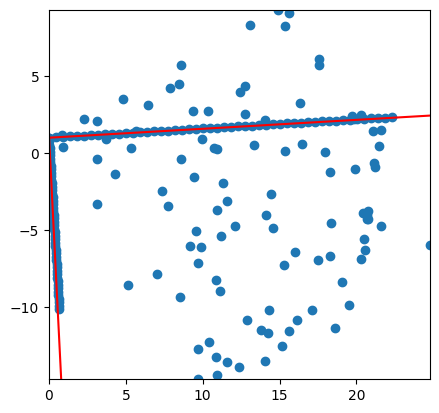

In [15]:
def iteration(cloud: np.ndarray, precision: float = 0.01) -> tuple[int, tuple[float, float, float]]:
    seed = cloud[:, np.random.randint(0, cloud.shape[1]-1, size=2)]
    line = line_by_2_points(seed)
    d = dist_points2line(cloud, line)
    return np.count_nonzero(d <= precision), line

    
f = lambda a1, a2, a3, x: (a1*x + a3)/-a2
d = dict(iteration(cloud) for _ in range(1000))
line = d[max(d)]
d = dict(iteration(cloud[:, dist_points2line(cloud, line) > 0.1]) for _ in range(1000))
line2 = d[max(d)]
x = np.array([np.min(cloud[0]), np.max(cloud[0])])
plt.scatter(*cloud)
plt.plot(x, f(*line, x), c='r')
plt.plot(x, f(*line2, x), c='r')
plt.gca().set_aspect('equal')
plt.xlim(*x)
plt.ylim([np.min(cloud[1]), np.max(cloud[1])])

3D

In [ ]:
f = lambda a1, a2, a3, a4, x, y: (a1*x + a2*y + a4)/-a3
